## Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import cv2
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from datetime import datetime


## Constants

In [ ]:

NUM_CLASSES = 5


CHANNELS = 3

IMAGE_RESIZE = 150
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
# EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 200
BATCH_SIZE_VALIDATION = 200

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
ROOT_PATH='/content/drive/MyDrive/Tasarım Çalışması Dataset/Tooth Decay Dataset/'

## Access and prepare data for training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
calculus_data_path="Calculus/Calculus/"
caries_data_path="Data caries/Data caries/caries augmented data set/preview/"
gingivitis_data_path="Gingivitis/Gingivitis/"
mouth_ulcer_data_path="Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview/"
tooth_discoloration_data_path='Tooth Discoloration/Tooth Discoloration/Tooth_discoloration_augmented_dataser/preview/'
hypodontia_data_path="hypodontia/hypodontia/"
healthy_data_path="healthy/"

In [ ]:
calculus_data=os.listdir(ROOT_PATH+calculus_data_path)
caries_data=os.listdir(ROOT_PATH+caries_data_path)
gingivits_data=os.listdir(ROOT_PATH+gingivitis_data_path)
# tooth_discoloration_data=os.listdir(ROOT_PATH+tooth_discoloration_data_path)
hypodontia_data=os.listdir(ROOT_PATH+hypodontia_data_path)
healthy_data=os.listdir(ROOT_PATH+healthy_data_path)

In [ ]:
for i in range(len(calculus_data)):
  calculus_data[i]=ROOT_PATH+calculus_data_path+calculus_data[i]

In [ ]:
for i in range(len(gingivits_data)):
  gingivits_data[i]=ROOT_PATH+gingivitis_data_path+gingivits_data[i]

In [ ]:
for i in range(len(caries_data)):
  caries_data[i]=ROOT_PATH+caries_data_path+caries_data[i]

In [ ]:
for i in range(len(hypodontia_data)):
  hypodontia_data[i]=ROOT_PATH+hypodontia_data_path+hypodontia_data[i]

In [ ]:
for i in range(len(healthy_data)):
  healthy_data[i]=ROOT_PATH+healthy_data_path+healthy_data[i]

In [ ]:
# for i in range(len(tooth_discoloration_data)):
#   tooth_discoloration_data[i]=ROOT_PATH+tooth_discoloration_data_path+tooth_discoloration_data[i]

In [ ]:
print(f"Length of the calculus data is: {len(calculus_data)}")
print(f"Length of the caries  data is: {len(caries_data)}")
print(f"Length of the gingivit data is: {len(gingivits_data)}")
# print(f"Length of the mouth ulcer data is: {len(mouth_ulcer_data)}")
# print(f"Length of the tooth discoloration data is: {len(tooth_discoloration_data)}")
print(f"Length of the hypodontia data is: {len(hypodontia_data)}")
print(f"Length of the healthy data is: {len(healthy_data)}")

Length of the calculus data is: 1191
Length of the caries  data is: 2254
Length of the gingivit data is: 2349
Length of the hypodontia data is: 1251
Length of the healthy data is: 1670


## Vizualization Of Dataset

In [ ]:
def visualize(data_path):
  fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(10,10))
  for row in range(3):
    for col in range(3):
      random_idx_col=random.randint(0,len(data_path))
      random_image=plt.imread(data_path[random_idx_col])
      axs[row][col].imshow(random_image)



### Gingivitis Data

Gingivitis is a common and mild form of gum disease (periodontal disease) that causes irritation, redness, and swelling (inflammation) of your gingiva, the part of your gum around the base of your teeth.

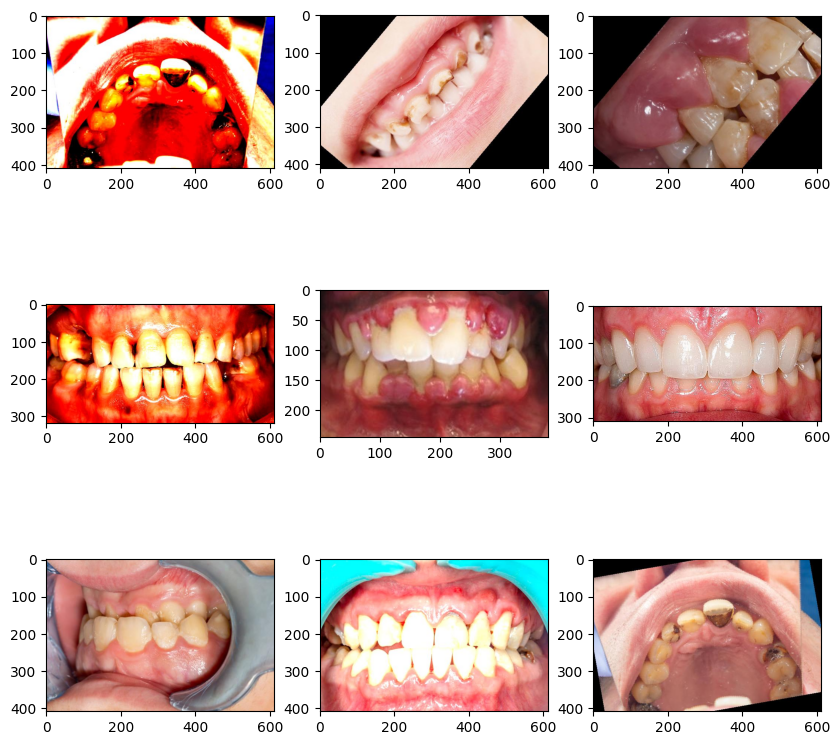

In [ ]:
visualize(gingivits_data)

### Caries Data

Dental caries or tooth decay, which is a common condition where the hard tissues of the tooth, such as enamel and dentin, are damaged by acids produced by bacteria.

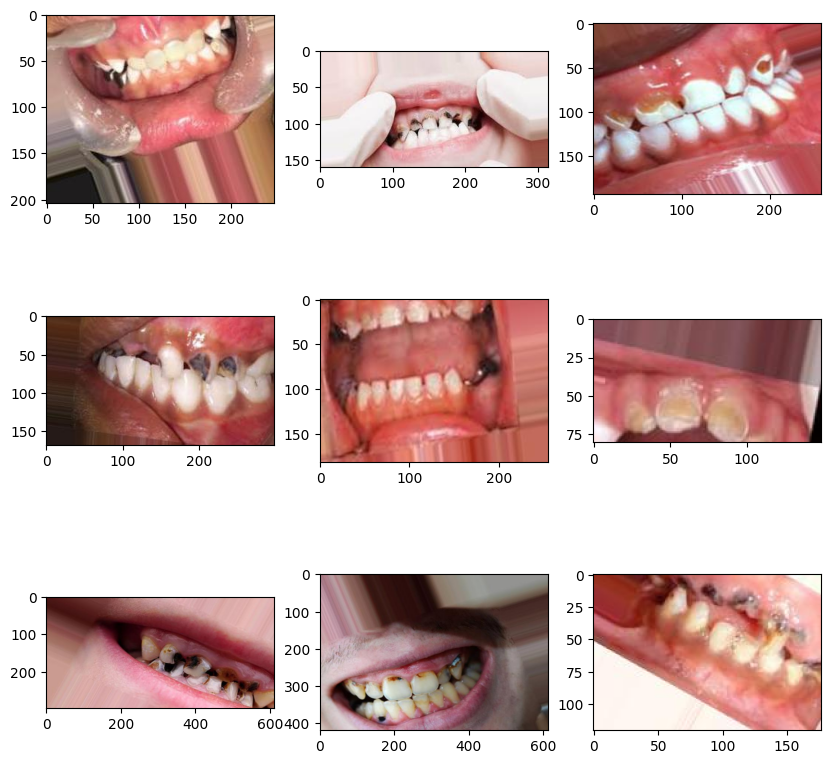

In [ ]:
visualize(caries_data)

### Calculus Data

Tooth calculus, also known as dental calculus or tartar, is a hardened deposit that forms on the teeth. It is a result of the mineralization of dental plaque, which is a soft and sticky film of bacteria that constantly forms on the teeth and gums. Dental calculus can contribute to various oral health issues and is commonly removed through professional dental cleanings.

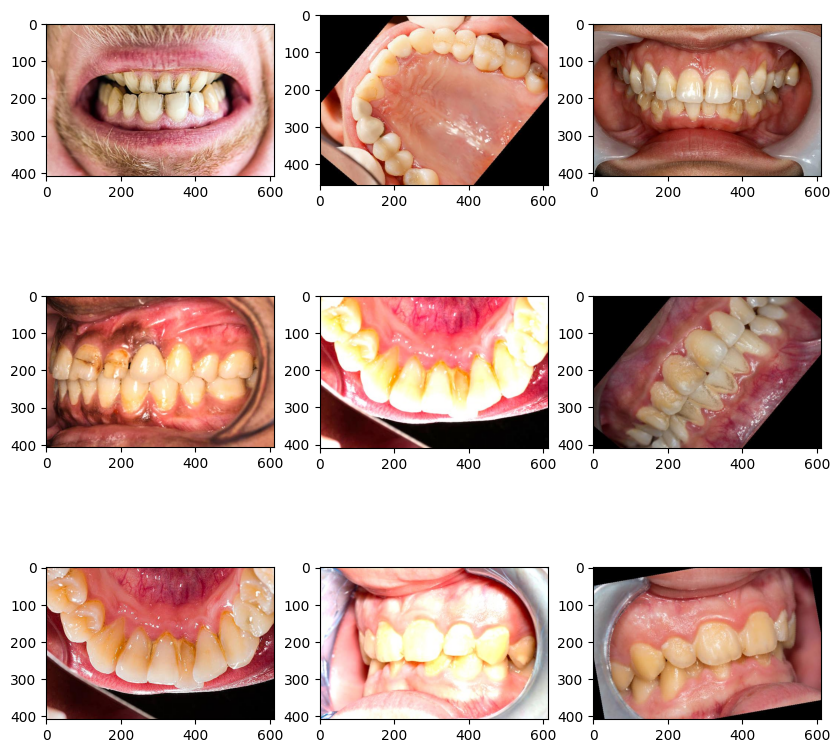

In [ ]:
visualize(calculus_data)

### Hypodontia

Hypodontia is a dental condition characterized by the developmental absence of one or more teeth, excluding the third molars (wisdom teeth). In individuals with hypodontia, certain permanent teeth fail to develop or do not fully emerge in the oral cavity.

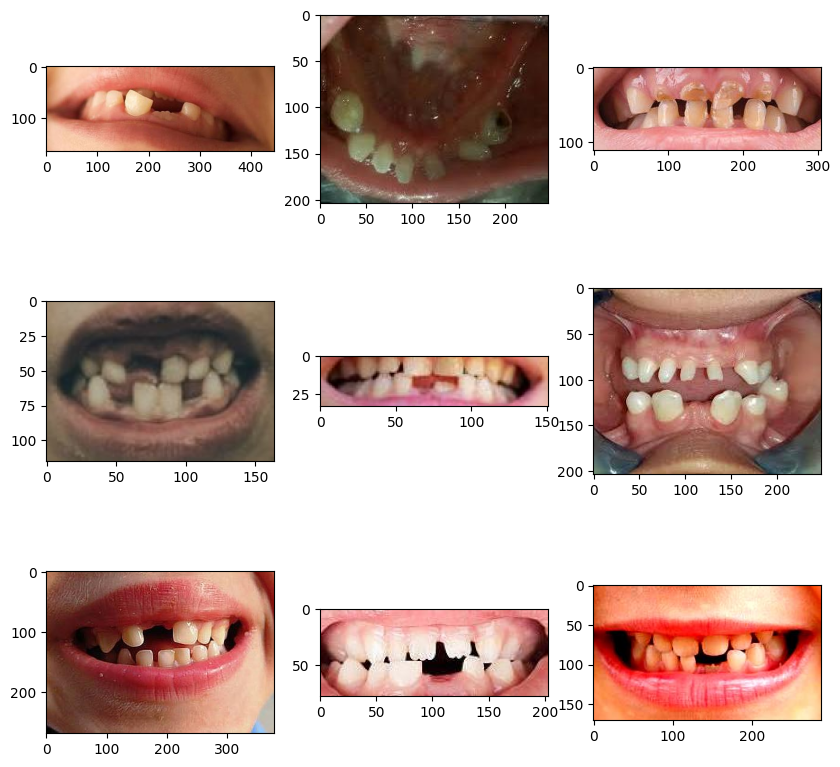

In [ ]:
visualize(hypodontia_data)

## Healthy

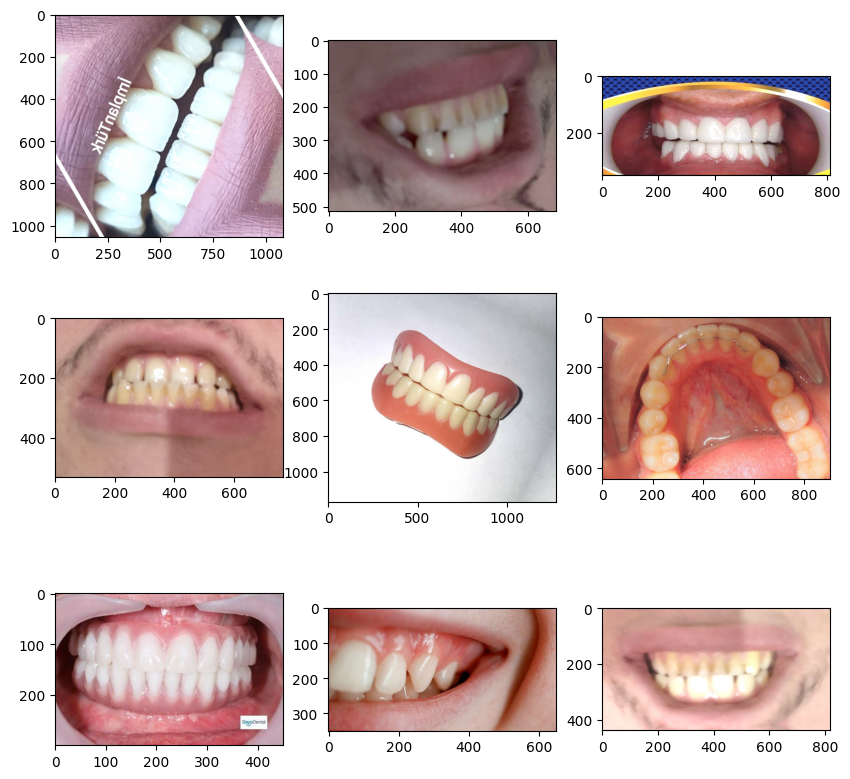

In [ ]:
visualize(healthy_data)

In [ ]:
classes=os.listdir(ROOT_PATH)

In [ ]:
classes

['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']

## Train, Validation, Test Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

classes=os.listdir(ROOT_PATH)
print(classes)

X = []
y = []



print(classes)

for i, cls in enumerate(classes):

    if cls=='Gingivitis':
      X.extend(gingivits_data)
      y.extend([i]*len(gingivits_data))
    elif cls=='hypodontia':
      X.extend(hypodontia_data)
      y.extend([i]*len(hypodontia_data))
    elif cls=='Data caries':
      X.extend(caries_data)
      y.extend([i]*len(caries_data))
    elif cls=='Calculus':
      X.extend(calculus_data)
      y.extend([i]*len(calculus_data))
    elif cls=='healthy':
      X.extend(healthy_data)
      y.extend([i]*len(healthy_data))




['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']
['Gingivitis', 'hypodontia', 'Data caries', 'Calculus', 'healthy']


In [ ]:
len(y)

8715

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [ ]:
y_train

[2,
 0,
 3,
 4,
 0,
 2,
 2,
 0,
 0,
 1,
 4,
 4,
 0,
 1,
 3,
 2,
 4,
 3,
 0,
 3,
 2,
 3,
 4,
 2,
 4,
 0,
 4,
 0,
 1,
 2,
 4,
 4,
 2,
 3,
 4,
 2,
 2,
 2,
 0,
 3,
 2,
 2,
 0,
 0,
 2,
 3,
 2,
 3,
 4,
 4,
 0,
 2,
 1,
 0,
 0,
 4,
 3,
 0,
 0,
 0,
 0,
 4,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 3,
 0,
 3,
 4,
 2,
 3,
 4,
 0,
 2,
 1,
 2,
 2,
 3,
 3,
 2,
 0,
 1,
 2,
 4,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 4,
 1,
 2,
 4,
 2,
 3,
 4,
 3,
 0,
 3,
 2,
 0,
 0,
 2,
 4,
 0,
 4,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 4,
 3,
 4,
 0,
 2,
 2,
 0,
 2,
 3,
 1,
 2,
 0,
 0,
 3,
 2,
 2,
 0,
 3,
 0,
 4,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 1,
 4,
 4,
 1,
 2,
 1,
 0,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 0,
 2,
 4,
 1,
 1,
 4,
 4,
 0,
 4,
 0,
 0,
 3,
 3,
 2,
 1,
 3,
 0,
 3,
 2,
 2,
 4,
 0,
 1,
 2,
 3,
 2,
 4,
 1,
 2,
 4,
 0,
 4,
 0,
 0,
 2,
 0,
 0,
 3,
 2,
 0,
 3,
 1,
 2,
 4,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 3,
 2,
 0,
 0,
 4,
 2,
 4,
 0,
 2,
 1,
 4,
 1,
 0,
 1,
 1,
 4,
 2,
 0,
 0,
 2,


In [ ]:
X_train.shape

(6972,)

## DataFrame

In [ ]:
all_dataset_df=pd.DataFrame({'filename':X,'class':y})
all_dataset_df=all_dataset_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(f"Length of all dataset is {len(all_dataset_df)}")

Length of all dataset is 8715


In [ ]:
# X_train ve y_train verilerinizi bir DataFrame'e yükleyin
train_df = pd.DataFrame({'filename': X_train, 'class': y_train})
test_df=pd.DataFrame({'filename':X_test,'class':y_test})

In [ ]:
# Verilerinizi karıştırın
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_df

filename  class
0     /content/drive/MyDrive/Tasarım Çalışması Dat...      3
1     /content/drive/MyDrive/Tasarım Çalışması Dat...      3
2     /content/drive/MyDrive/Tasarım Çalışması Dat...      4
3     /content/drive/MyDrive/Tasarım Çalışması Dat...      4
4     /content/drive/MyDrive/Tasarım Çalışması Dat...      2
...                                                 ...    ...
6967  /content/drive/MyDrive/Tasarım Çalışması Dat...      0
6968  /content/drive/MyDrive/Tasarım Çalışması Dat...      0
6969  /content/drive/MyDrive/Tasarım Çalışması Dat...      0
6970  /content/drive/MyDrive/Tasarım Çalışması Dat...      2
6971  /content/drive/MyDrive/Tasarım Çalışması Dat...      2

[6972 rows x 2 columns]

## Distrubution Of Labels

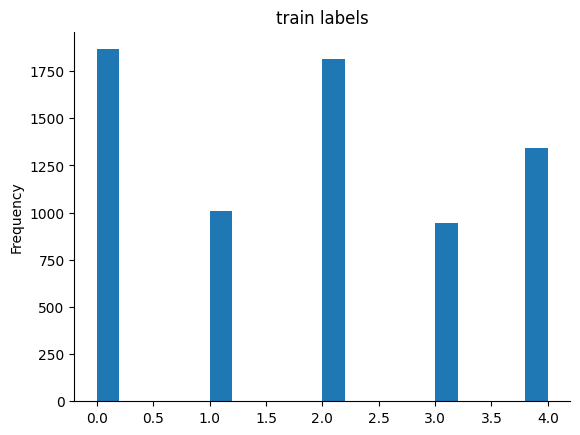

In [ ]:
from matplotlib import pyplot as plt
train_df['class'].plot(kind='hist', bins=20, title='train labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Distrubution Of Test Labels

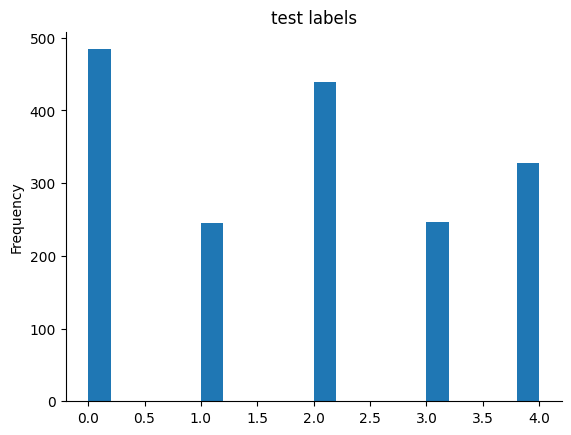

In [ ]:
from matplotlib import pyplot as plt
test_df['class'].plot(kind='hist', bins=20, title='test labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Dataframe Class Column Type Conversions

In [ ]:
all_dataset_df["class"]=all_dataset_df["class"].astype("str")
train_df["class"] = train_df["class"].astype("str")
test_df["class"] = test_df["class"].astype("str")

## Create Batch Generator


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale = 1/255.0
)


## Model Building

In [ ]:
def build_model_xception():
  model=Sequential()
  base_model = Xception(weights="imagenet", include_top=False,input_shape=(150,150,3))

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)
  x = Dense(512, activation ='relu')(x)
  x = BatchNormalization()(x)
  #x = Dropout(0.5)(x)

  x = Dense(256, activation ='relu')(x)
  x = BatchNormalization()(x)


  predictions = Dense(5, activation ='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  # checkPointer=ModelCheckpoint(filepath='XceptionCrossValidatedWith5Class.hdf5',verbose=1,save_best_only=True)
  model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


## Stratified KFold Cross Validation

### What's the stratified KFold Cross Validation

In [ ]:
num_folds=5
# Veri setimizin indisleri
indices = np.arange(len(train_df))

val_accuracies=[]
train_accuracies=[]
# StratifiedKFold ile indisleri bölün
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in skf.split(indices, train_df['class']):
    train_data = train_df.iloc[train_index]
    test_data = train_df.iloc[test_index]

    # train_data ve test_data ile generatorları oluşturun
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    valid_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        xcol='filename',
        ycol='class',
        batch_size=32,
        target_size=(150, 150),
        class_mode='categorical',
        color_mode='rgb'
    )

    # Created Model
    model = build_model_xception()

    history=model.fit(train_generator, epochs=10, validation_data=valid_generator,batch_size=200)
    train_accuracy=history.history['accuracy'] # Tüm epochların değerini al
    val_accuracy = history.history['val_accuracy']  # Tüm epochların değerlerini al
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


Found 5577 validated image filenames belonging to 5 classes.
Found 1395 validated image filenames belonging to 5 classes.
83683744/83683744 [==============================] - 3s 0us/step


Epoch 1/10
175/175 [==============================] - 4246s 24s/step - loss: 0.6449 - accuracy: 0.7658 - val_loss: 0.7416 - val_accuracy: 0.7405
Epoch 2/10
175/175 [==============================] - 41s 236ms/step - loss: 0.3403 - accuracy: 0.8619 - val_loss: 0.2943 - val_accuracy: 0.8846
Epoch 3/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2639 - accuracy: 0.8912 - val_loss: 0.3928 - val_accuracy: 0.8832
Epoch 4/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2341 - accuracy: 0.8987 - val_loss: 0.3542 - val_accuracy: 0.8796
Epoch 5/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2352 - accuracy: 0.8999 - val_loss: 0.2637 - val_accuracy: 0.8968
Epoch 6/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2170 - accuracy: 0.9039 - val_loss: 0.5236 - val_accuracy: 0.8294
Epoch 7/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2076 - accuracy: 0.9109 - val_loss: 0.3561 - val_ac

Epoch 1/10
175/175 [==============================] - 63s 252ms/step - loss: 0.6307 - accuracy: 0.7691 - val_loss: 0.4165 - val_accuracy: 0.8330
Epoch 2/10
175/175 [==============================] - 43s 245ms/step - loss: 0.3260 - accuracy: 0.8687 - val_loss: 0.3804 - val_accuracy: 0.8444
Epoch 3/10
175/175 [==============================] - 43s 245ms/step - loss: 0.2971 - accuracy: 0.8809 - val_loss: 0.3222 - val_accuracy: 0.8631
Epoch 4/10
175/175 [==============================] - 43s 248ms/step - loss: 0.2638 - accuracy: 0.8892 - val_loss: 0.2939 - val_accuracy: 0.8717
Epoch 5/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2296 - accuracy: 0.9007 - val_loss: 0.8699 - val_accuracy: 0.7634
Epoch 6/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2240 - accuracy: 0.9041 - val_loss: 0.3208 - val_accuracy: 0.8674
Epoch 7/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2425 - accuracy: 0.8958 - val_loss: 0.6296 - val_ac

Epoch 1/10
175/175 [==============================] - 66s 264ms/step - loss: 0.6431 - accuracy: 0.7621 - val_loss: 0.8270 - val_accuracy: 0.7468
Epoch 2/10
175/175 [==============================] - 43s 244ms/step - loss: 0.3507 - accuracy: 0.8627 - val_loss: 0.4072 - val_accuracy: 0.8364
Epoch 3/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2982 - accuracy: 0.8793 - val_loss: 0.4117 - val_accuracy: 0.8350
Epoch 4/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2636 - accuracy: 0.8949 - val_loss: 0.2587 - val_accuracy: 0.8809
Epoch 5/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2137 - accuracy: 0.9116 - val_loss: 0.3874 - val_accuracy: 0.8630
Epoch 6/10
175/175 [==============================] - 43s 245ms/step - loss: 0.2315 - accuracy: 0.8991 - val_loss: 0.4108 - val_accuracy: 0.8121
Epoch 7/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2112 - accuracy: 0.9098 - val_loss: 0.3188 - val_ac

Epoch 1/10
175/175 [==============================] - 64s 253ms/step - loss: 0.6855 - accuracy: 0.7576 - val_loss: 0.6852 - val_accuracy: 0.7245
Epoch 2/10
175/175 [==============================] - 43s 246ms/step - loss: 0.3675 - accuracy: 0.8498 - val_loss: 0.4760 - val_accuracy: 0.8156
Epoch 3/10
175/175 [==============================] - 43s 247ms/step - loss: 0.3366 - accuracy: 0.8698 - val_loss: 0.4921 - val_accuracy: 0.8343
Epoch 4/10
175/175 [==============================] - 43s 248ms/step - loss: 0.2813 - accuracy: 0.8863 - val_loss: 0.3057 - val_accuracy: 0.8709
Epoch 5/10
175/175 [==============================] - 44s 248ms/step - loss: 0.2540 - accuracy: 0.8955 - val_loss: 0.4208 - val_accuracy: 0.8235
Epoch 6/10
175/175 [==============================] - 43s 248ms/step - loss: 0.2317 - accuracy: 0.9034 - val_loss: 0.3902 - val_accuracy: 0.8529
Epoch 7/10
175/175 [==============================] - 43s 247ms/step - loss: 0.2068 - accuracy: 0.9093 - val_loss: 0.4107 - val_ac

Epoch 1/10
175/175 [==============================] - 64s 255ms/step - loss: 0.6529 - accuracy: 0.7594 - val_loss: 0.8207 - val_accuracy: 0.6815
Epoch 2/10
175/175 [==============================] - 43s 246ms/step - loss: 0.3579 - accuracy: 0.8596 - val_loss: 0.3493 - val_accuracy: 0.8608
Epoch 3/10
175/175 [==============================] - 43s 247ms/step - loss: 0.2764 - accuracy: 0.8881 - val_loss: 0.3262 - val_accuracy: 0.8824
Epoch 4/10
175/175 [==============================] - 43s 246ms/step - loss: 0.2623 - accuracy: 0.8937 - val_loss: 1.0122 - val_accuracy: 0.6729
Epoch 5/10
175/175 [==============================] - 43s 246ms/step - loss: 0.3124 - accuracy: 0.8763 - val_loss: 0.2418 - val_accuracy: 0.8895
Epoch 6/10
175/175 [==============================] - 43s 247ms/step - loss: 0.2191 - accuracy: 0.9061 - val_loss: 0.2893 - val_accuracy: 0.8838
Epoch 7/10
175/175 [==============================] - 43s 247ms/step - loss: 0.2024 - accuracy: 0.9098 - val_loss: 0.3218 - val_ac

In [ ]:
# Her bir k-fold iterasyonunun doğrulama doğruluğunu yazdırın
for i, acc in enumerate(val_accuracies, 1):
    print(f'Fold {i}: Validation Accuracy = {acc}')

# Ortalama doğrulama doğruluğunu hesaplayın
average_val_accuracy = np.mean(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Fold 1: Validation Accuracy = [0.7405018210411072, 0.884587824344635, 0.8831540942192078, 0.8795698881149292, 0.896774172782898, 0.8293907046318054, 0.8637992739677429, 0.8867383599281311, 0.8817204236984253, 0.8623656034469604]
Fold 2: Validation Accuracy = [0.832974910736084, 0.8444444537162781, 0.8630824089050293, 0.8716846108436584, 0.7634408473968506, 0.8673835396766663, 0.7706093192100525, 0.8666666746139526, 0.8767024874687195, 0.8652330040931702]
Fold 3: Validation Accuracy = [0.7467718720436096, 0.8364418745040894, 0.8350071907043457, 0.8809182047843933, 0.8629842400550842, 0.8120516538619995, 0.8536585569381714, 0.8572453260421753, 0.8156384229660034, 0.7718794941902161]
Fold 4: Validation Accuracy = [0.72453373670578, 0.8156384229660034, 0.8342897891998291, 0.8708751797676086, 0.8235294222831726, 0.8529411554336548, 0.8601147532463074, 0.8837876319885254, 0.8823529481887817, 0.8579626679420471]
Fold 5: Validation Accuracy = [0.6814920902252197, 0.860832154750824, 0.882352948

## Draw Loss and Accuracy Graphs

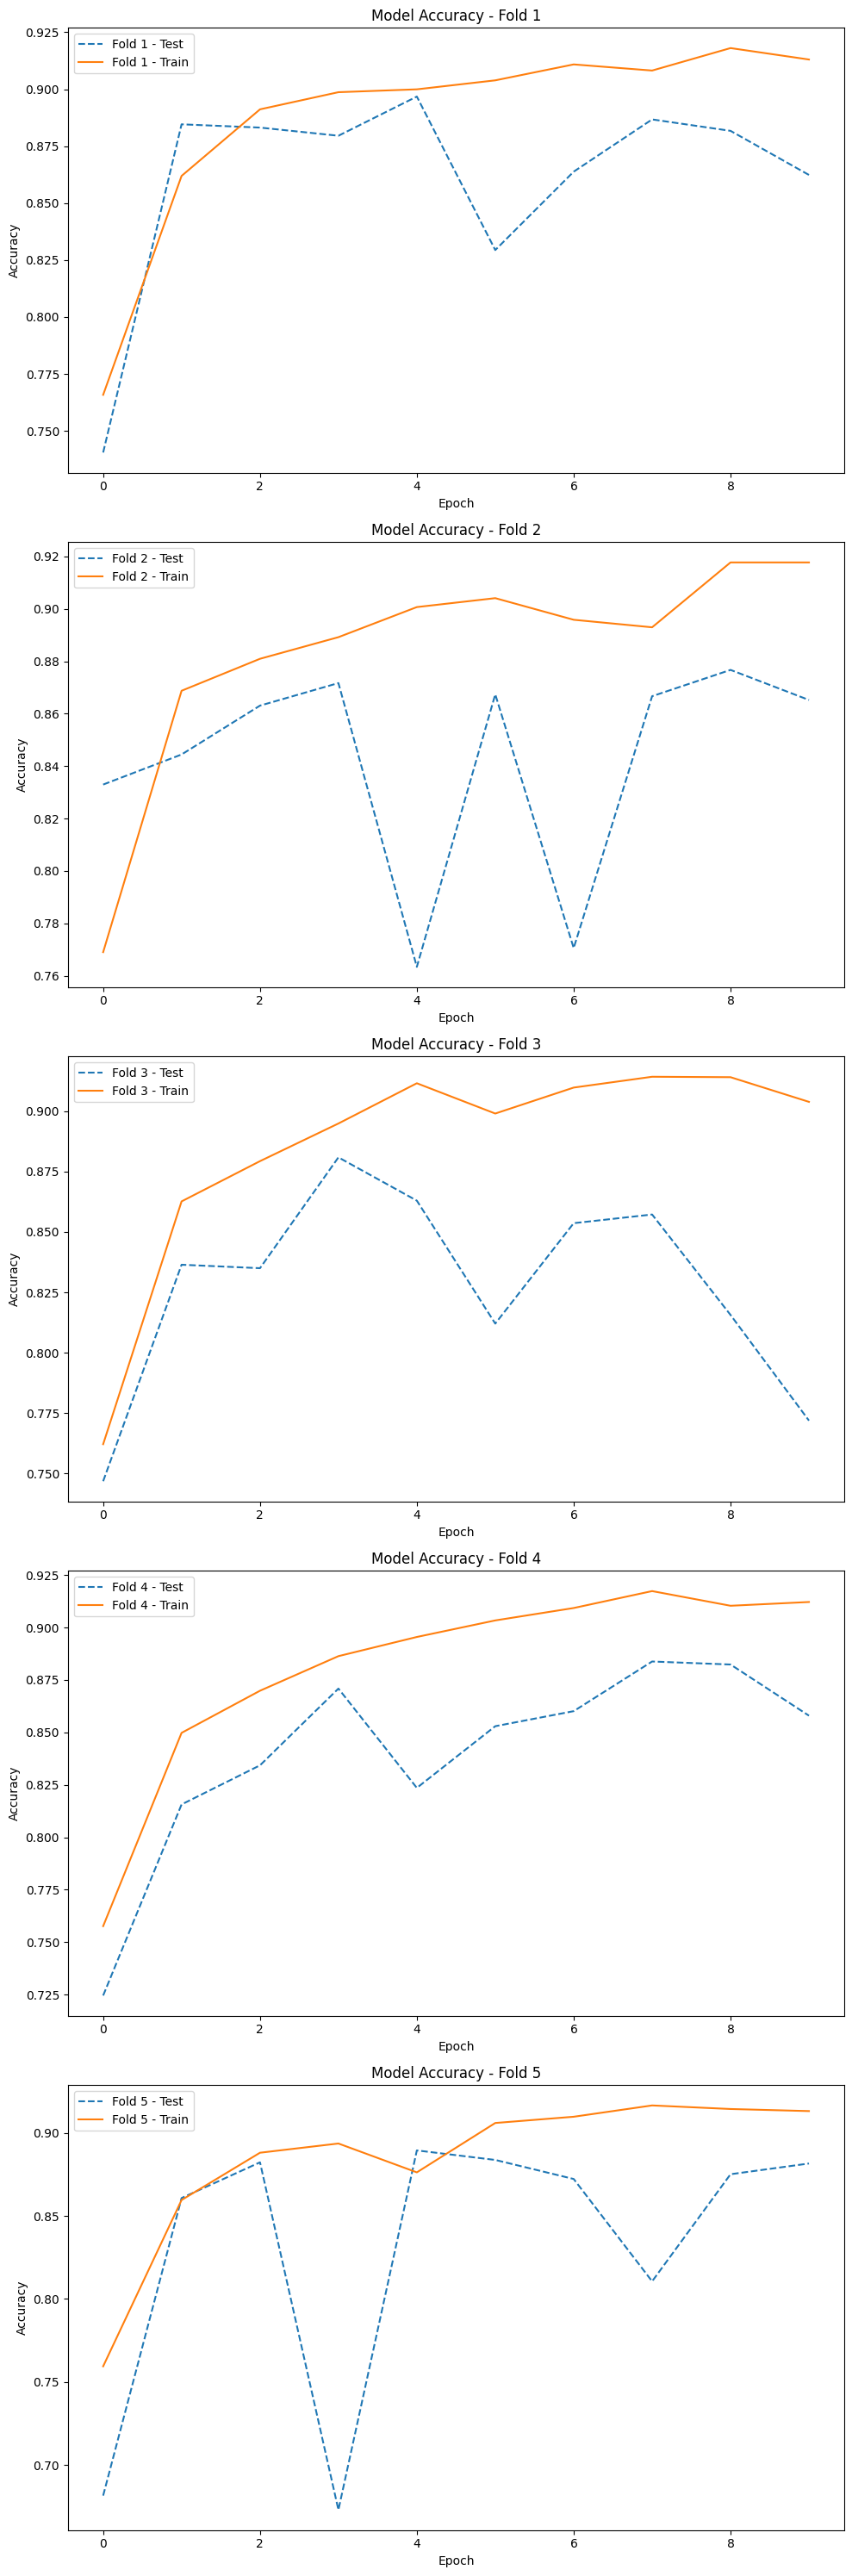

In [ ]:
fig, axs = plt.subplots(len(val_accuracies), 1, figsize=(10, 6 * len(val_accuracies)))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies)):
    axs[i].plot(val_accuracies[i], label=f'Fold {i+1} - Test', linestyle='--')
    axs[i].plot(train_accuracies[i], label=f'Fold {i+1} - Train')

    axs[i].set_title(f'Model Accuracy - Fold {i+1}')
    axs[i].set_ylabel('Accuracy')
    axs[i].set_xlabel('Epoch')
    axs[i].legend(loc='upper left')  # İsteğe bağlı: Konumu ayarlayabilirsiniz

plt.tight_layout()  # İsteğe bağlı: Alt grafikler arasındaki boşluğu ayarlar
plt.show()

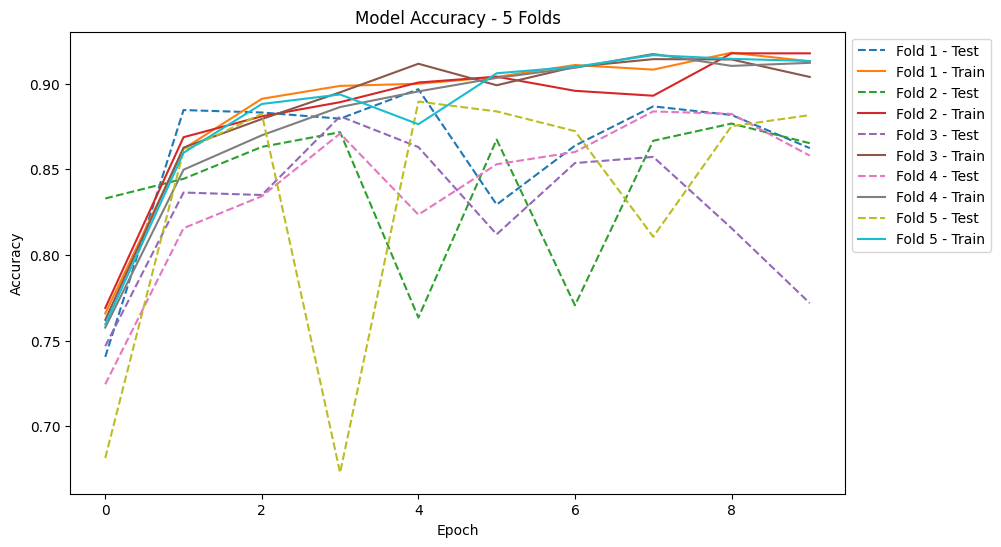

In [ ]:
# Her bir fold için grafiği tek bir figürde göstermek için
plt.figure(figsize=(10, 6))  # İsteğe bağlı: Figür boyutunu ayarlayabilirsiniz

for i in range(len(val_accuracies)):
    plt.plot(val_accuracies[i], label=f'Fold {i+1} - Test', linestyle='--')
    plt.plot(train_accuracies[i], label=f'Fold {i+1} - Train')

plt.title('Model Accuracy - 5 Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # İsteğe bağlı: Konumu ayarlayabilirsiniz
plt.show()

## Draw RoC curve

## Confusion Matrix

## Make prediction

In [ ]:
def make_prediction():
  """
    Generate a random prediction on a test image using the trained model and display the result.

    The function randomly selects an image from the test dataset, preprocesses it, and then uses
    the trained model to make a prediction. The top predicted classes and their probabilities are printed.
    The actual label of the selected image is also displayed.

    Returns:
        None
  """

  random_idx=random.randint(0,len(X_test)-1)
  image=plt.imread(X_test[random_idx])
  image=cv2.resize(image,(150,150))/255
  img_array=np.expand_dims(image,axis=0)
  plt.imshow(image)

  prediction=model.predict(img_array)


  class_probabilities=prediction[0]

  # İlk n sınıfın olasılık değerlerini almak istiyorsanız
  top_n_classes = np.argsort(class_probabilities)[-5:][::-1]

  # Top n sınıfın olasılık değerlerini yazdırın
  for i in top_n_classes:
    if i==0:
      formatted_prob = "{:.{}f}".format(class_probabilities[i], 8)
      print(f"Gingivitis: {formatted_prob}")
    elif i==1:
      formatted_prob = "{:.{}f}".format(class_probabilities[i], 8)
      print(f"Hypodontia: {formatted_prob}")
    elif i==2:
      formatted_prob = "{:.{}f}".format(class_probabilities[i], 8)
      print(f"Data Caries: {formatted_prob}")
    elif i==3:
      formatted_prob = "{:.{}f}".format(class_probabilities[i], 8)
      print(f"Calculus: {formatted_prob}")
    elif i==4:
      formatted_prob = "{:.{}f}".format(class_probabilities[i], 8)
      print(f"Healthy: {formatted_prob}")

  if y_test[random_idx]==0:
    print(f"Actual Label of Image is Gingivitis")
  elif y_test[random_idx]==1:
    print(f"Actual Label of Image is Hypodontia")
  elif y_test[random_idx]==2:
    print(f"Actual Label of Image is Data Caries")
  elif y_test[random_idx]==3:
    print(f"Actual Label of Image is Calculus")
  elif y_test[random_idx]==4:
    print(f"Actual Label of Image is Healthy")


1/1 [==============================] - 1s 1s/step
Hypodontia: 0.99998415
Healthy: 0.00000786
Data Caries: 0.00000525
Calculus: 0.00000175
Gingivitis: 0.00000090
Actual Label of Image is Hypodontia


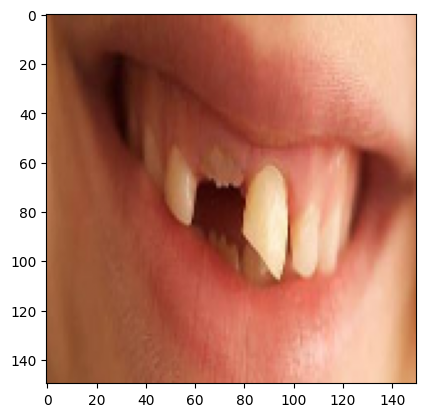

In [ ]:
make_prediction()

## Save Model

In [ ]:
model.save('cross_validated_model_last.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Download Model

In [ ]:
from google.colab import files
# Model dosyasının ismi
model_filename = '/content/cross_validated_model_last.h5'

# Dosyayı indir
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>